# ML with Large Datasets
----
## Dataset Description
In order to explore these Spark API, we use the [following dataset](). The data is from a population and housing census of some country ```X```  not identified for privacy reasons although this data is a very small subset of the actual data. 
Each row in the data represent a single individual in the population. 
 A summary of column description is provided below:
- **Geographic identifiers:** PROVINCE, REGION, DISTRICT, COMMUNE,MILIEU ,
       IDMEN, IDINDIV. This type of data has a somewhat hierarchical structure. We have a household (think of it as family), IDMEN-household ID. Within each household, we have individuals, IDINDIV - individual
       > 
- **MILIEU:** A classification of whether this person lived in urban or rural area. ```2-Rural, 1-Urban```
- **Sex**. ```P05```==>[1	- Male 2	- Female]
- **P19 Languages spoken**. What languages the person can speak.This variable is split into 4 variables as follows: ```P19MG, P19FR, P19AN, P19AU``` for local language, English, French and any other language.
- **P20, Literacy**. Whether the person can read and write any of the 3 languages given. Note that there three variables each representing each language. A local language, French and English. For each language, the value 1 means they can read and write in the language while 2 means they cannot.The variables are ```P20MG (local language), P20FR (French), P20AN (English), P20AU (other)```. 
- **P03:** whether the person is the head of the household, wife. child etc==>[0- Chef de Ménage (CM) 1- Conjoint(e) (CJ) 2-	Fils/Fille3-	Père/Mère 4-	Beau-Père/Belle-Mère 5-	Beau-Fils/Belle-Fille 6-	Petit fils/Petite-fille
 Autre Proche du CM 8- Autre proche du CJ 9 -Sans lien de parenté]

- **Age:**. Person's date of birth is given by column ```P07M``` (month of birth), ```P07A``` (year of birth) and ```P08``` (age)
- **Marital status:** ```P28``` (whether the person is married or not)==>[1-	Célibataire, 2-	Marié(e), 3-	Divorcé(e)/Séparé(e), 4-	Veuf(ve)]. This question is asked to residents who are 12 years or older. 
- **Age at first marriage**. ```P29``` (age at marriage).The question was like this: How old was <NAME> when he/she got married for the first time?
- **School attendance:** ```P21``` ==>[0 N'a Jamais fréquenté 1-A	fréquenté 2- Fréquente actuellement]
- **Highest school level attended:**```P22N```. This variable represents highest level of school attended. The question was asked like this: What is the highest level of education that (name) achieved during his studies?
 > 1. Preschool; 2. Primary-school; 3. Secondary; 4. Technical college; 5. University 
 - **Number of years of school completed at a particular level:** ```P22C``` Years completed at that level. A value of 0 means the person didnt complete the first year of education at that level. 
 > Preschool(0-2); Primary-school(0-5);Secondary(0-7); Technical college (0-7); University (0-7)
 
- **Whether the person worked or not:** ```P23```==> [1-	0ccupé 2-	Chômeur 3-	En quête du 1er emploi 4-	Ménagère 5-	Elève/Etudiant 6-	Retraité 7- lncapacité à travailler 8- Autre]

## The Task
The Ministry of Health in the country has expressed concern about the prevalence of early marriages among young individuals (both men and women). They have tasked you with investigating the factors contributing to early marriages. For the purpose of this analysis, individuals who get married at the age of 18 or younger are classified as having married early or belonging to the early marriage category. Beyond conducting exploratory analysis, the Ministry has requested that you develop a model to predict whether a person is likely to marry young, based on factors such as place of residence, household size, parents' education levels, and other relevant variables. In summary, these are the project goals.
1. Perfom explotaory analysis to understand early marriages 
2. Build a Machine Learning model which can predict whether a person will get married early or not.
3. Report on the model performance and efficacy

## Python setup

In [1]:
## Python setup
from datetime import datetime
from IPython.display import Image
import pandas as pd
# Suppress scientific notation globally
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC, AdaBoostClassifier as Ada
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from tabulate import tabulate

/home/linuce/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/linuce/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


No Bottleneck unit testing available.


# Inputs Paths, Global Variables and Parameters
Lets provide paths to input files we will use. 
Its a good practice to create these as global variables. Also, use Python module ```Path``` from pathlib to manage file paths. 

In [2]:
# path to hh_data.txt
HH_DATA = "./data/ResidentIBEIPM.csv"

# Decide which columns to keep
COLS_TO_KEEP = ["PROVINCE", "REGION", "DISTRICT", "COMMUNE","MILIEU", "MilieuCarto", "IDMEN", "IDINDIV", "P05", "P19MG", "P19FR", "P19AN", "P19AU", "P20MG", "P20FR", "P20AN", "P20AU", "P03", "P08", "P28", "P29", "P21", "P22N", "P22C", "P23"]
# Regular household size threshold
# use quintiles to determine the threshold
HH_SIZE_THRESHOLD = 0.99

# CHILFREN AGE THRESHOLD
CHILDREN_AGE_THRESHOLD = 15
ELDERY_AGE_THRESHOLD = 65
EARLY_MARRIAGE_AGE_THRESHOLD = 18

In [55]:
spark = SparkSession.builder\
                .appName("LargeDatasetProcessing")\
                .master(f"local[10]")\
                .config("spark.driver.memory", "56g")\
                .config("spark.executor.memory", "56g")\
                .config("spark.memory.offHeap.enabled", "true")\
                .config("spark.sql.shuffle.partitions", "40")\
                .config("spark.memory.offHeap.size", "4g")\
                .config("spark.driver.bindAddress", "127.0.0.1") \
                .getOrCreate()

ConnectionRefusedError: [Errno 111] Connection refused

# Preprocess the Data

The objective here is to load the dataset, retain only the necessary columns to reduce its size, and enable faster processing. During preprocessing, we aim to clean up the columns and convert numeric columns into proper numeric data types.

## Load the Data

I use Spark for loading the data because it is faster than pandas. Alternatively, students can use the pandas "chunk" method to load data in manageable chunks. Another approach is to first load a small sample of the dataset, identify and document the required columns, and then load only those columns from the full dataset.

## Subset the Columns

Whether or not all columns were initially loaded, this step involves selecting only the required columns for further processing.

## Preprocess and Clean Data

For columns such as `age`, ensure they are in numeric format. Rows containing invalid or erroneous data can be removed as part of the cleaning process.


### Task-1-Loading and subsetting data

**Efficient Data Loading in PySpark**

To handle large datasets efficiently in PySpark, we employ the following strategies:

* **Partitioning:**
    * Divide the data into smaller, manageable chunks.
    * Choose a suitable column (e.g., `ID`) for partitioning.
    * This distributes processing across Spark executors, enhancing parallelism.
    * Optimize the number of partitions based on your cluster's size (generally, equal to the number of cores).

* **Caching:**
    * Cache the DataFrame in memory (if available) or on disk.
    * This significantly speeds up subsequent operations that rely on the cached data.

**Data Exploration with a Representative Sample**

After loading the data, we extract a small subset (e.g., 1% of the data) to facilitate initial exploration. This sample, while much smaller, provides a representative overview of the entire dataset, enabling us to:

* Gain initial insights into data characteristics.
* Identify potential issues (e.g., data quality problems).
* Develop and test exploratory data analysis techniques.

This approach allows for faster iteration and experimentation during the initial stages of the analysis process.


In [4]:

sdf = spark.read.csv(HH_DATA, header=True, sep=",", inferSchema=True) \
          .repartition(4)  
sdf.cache()
sdf = sdf.sample(withReplacement=False, fraction=0.1, seed=42)

25/01/25 03:04:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Subset the Data
Keep only the columns we need and save a smaller dataset.

In [5]:
sdf2 = sdf.select(COLS_TO_KEEP)

In [6]:
# Repartition the DataFrame to 10 partitions
out_csv = "../data/proj-dataset-small"

sdf2.repartition(10).coalesce(1).write.csv(out_csv, header=True, sep=",", mode="overwrite")

25/01/25 03:27:20 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 168407 ms exceeds timeout 120000 ms
25/01/25 03:27:20 WARN SparkContext: Killing executors is not supported by current scheduler.
25/01/25 03:27:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

25/01/25 03:27:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

25/01/25 03:27:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

25/01/25 03:27:41 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

25/01/25 03:27:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

25/01/25 03:28:01 ERROR Inbox: Ignoring error                       (2 + 2) / 4]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach

25/01/25 03:28:11 ERROR Inbox: Ignoring error                       (0 + 1) / 1]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach

## Task-2-Data preprocessing

This process of our work help us to prepare and process and cleaning our dataset, by select appropriate variable that most correlate to our target varible.

- Rename columns for easy identification
- Perform data type conversion if necessary

In [29]:
# ==========================================================
# Load the smaller CSV fwe just created as pandas DataFrame
# ==========================================================
import os
import os
from glob import glob
# ==========================================================
# Load the smaller CSV fwe just created as pandas DataFrame
# ==========================================================
csv_files = glob(os.path.join(out_csv, 'part-*.csv'))

# Read and concatenate all part files into a single DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
df.head()

,PROVINCE,REGION,DISTRICT,COMMUNE,MILIEU,MilieuCarto,IDMEN,IDINDIV,P05,P19MG,...,P20AN,P20AU,P03,P08,P28,P29,P21,P22N,P22C,P23
0,1,14,141,14105,2,2,14105301010021015020230023,1410530101002011500230202302,2,1.00,...,2.00,2.00,1,66.00,2.00,16.00,1.00,2.00,2.00,7.00
1,2,23,232,23219,2,2,23219301010061009020610061,2321930101006010900610206105,2,1.00,...,2.00,2.00,7,20.00,1.00,NaN,2.00,3.00,6.00,5.00
2,6,62,623,62318,2,2,62318301050031006020210021,6231830105003010600210202101,2,1.00,...,2.00,2.00,0,58.00,3.00,25.00,1.00,2.00,2.00,1.00
3,2,25,252,25216,2,2,25216301070061008021260126,2521630107006010801260212606,2,1.00,...,2.00,2.00,2,7.00,NaN,NaN,0.00,NaN,NaN,8.00
4,6,62,621,62111,2,2,62111301100031008021080108,6211130110003010801080210804,2,1.00,...,2.00,2.00,8,4.00,NaN,NaN,9.00,1.00,1.00,NaN


In [30]:
# ====================================
# RENAME COLUMNS
# ====================================
# Rename the columns to more meaningful names for easy understanding and ide


df = df.rename(columns={
    'PROVINCE': 'province_id',
    'REGION': 'region_id',
    'DISTRICT': 'district_id',
    'COMMUNE': 'commune_id',
    'MILIEU': 'living_area_type',
    'MilieuCarto': 'milieu_carto_id',
    'IDMEN': 'hh_id',
    'IDINDIV': 'indiv_id',
    'P05': 'sex',
    'P19MG': 'language_local',
    'P19FR': 'language_french',
    'P19AN': 'language_english',
    'P19AU': 'language_other',
    'P20MG': 'literacy_local',
    'P20FR': 'literacy_french',
    'P20AN': 'literacy_english',
    'P20AU': 'literacy_other',
    'P03': 'relationship_to_head',
    'P08': 'age',
    'P28': 'marital_status',
    'P29': 'age_at_first_marriage',
    'P21': 'school_attendance',
    'P22N': 'highest_school_level',
    'P22C': 'years_of_school_completed',
    'P23': 'employment_status'
})

# Convert data types
df['sex'] = df['sex'].astype('category')
df['living_area_type'] = df['living_area_type'].astype('category')
df['marital_status'] = df['marital_status'].astype('category')
df['school_attendance'] = df['school_attendance'].astype('category')
df['relationship_to_head'] = df['relationship_to_head'].astype('category')
df['highest_school_level'] = df['highest_school_level'].astype('category')

### Add New Variables We Need

In some cases, key information we need to explore may not be readily available in the dataset. For example, to analyze households, we might need to create a new column to represent household size.

#### Household Size
Household size refers to the number of people in a household. The dataset provides a household identifier (`hh_id`) and an individual identifier (`indiv_id`). Using these, we can generate a new column called `household_size`.

#### Feature Engineering: Creating Additional Variables
Feature engineering is the process of transforming raw data into meaningful features that improve the performance of machine learning models. This involves selecting, creating, modifying, or aggregating data attributes to make them more informative and relevant to the task at hand. Feature engineering is inherently a creative task—there are no strict rules. As a data scientist or machine learning practitioner, it's up to you to explore the data, consult domain experts, and study relevant literature to design and test new features.

For this analysis, we can consider creating the following features, which may influence the age at first marriage:

- **Number of dependent children in the household**: Defined as the number of individuals aged 15 and younger.
- **Number of dependent adults in the household**: Defined as the number of individuals aged 65 and older.

#### Household Level Variables 
Note that we have two levels of analysis units here: the individual and the household. As such, variables such as household size, number of children, number of the eldery are all household level variables. Since the head of the family or head of the household has more power in determing what happens in the house, we can also add household head variables. Concretely, for each household, we can have variables named like this: hoh_age, hoh_educ, hoh_literacy etc.

In [31]:
def gen_var_hh_size(df, hh_id_col='hh_id'):
    """Generates variable hh_size and other household-related variables.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing individual-level data.
    hh_id_col : str, optional
        The name of the household ID column, by default 'hh_id'.

    Returns
    -------
    DataFrame
        The original DataFrame with added household-level variables.
    """

    # ======================================================
    # GENERATE HH SIZE
    # ======================================================
    # Calculate household size as the number of individuals in each household
    hh_size = df.groupby(hh_id_col).size().reset_index(name='hh_size')

    hh_size.head()
    # ======================================================
    # GENERATE NUMBER OF CHILDREN AND ELDERLY
    # ======================================================
    
    df['is_child'] = df['age'] <= CHILDREN_AGE_THRESHOLD
    num_children = df.groupby(hh_id_col)['is_child'].sum().reset_index(name='num_children')
    
    
    df['is_elderly'] = df['age'] >= ELDERY_AGE_THRESHOLD
    num_elderly = df.groupby(hh_id_col)['is_elderly'].sum().reset_index(name='num_elderly')
    
    # ======================================================
    # MERGE THE DATAFRAMES
    # ======================================================
    # Merge household size, number of children, and number of elderly with the original dataframe
    df = df.merge(hh_size, on=hh_id_col, how='left')
    df = df.merge(num_children, on=hh_id_col, how='left')
    df = df.merge(num_elderly, on=hh_id_col, how='left')

    # ======================================================
    # FILL NAs WITH 0
    # ======================================================
    # After merging, we may have some missing values (NAs), so replace them with 0
    df['num_children'] = df['num_children'].fillna(0)
    df['num_elderly'] = df['num_elderly'].fillna(0)

    # ======================================================
    # CHECK THAT WE HAVE ALL HH_ID
    # ======================================================
    # Make sure there are no missing household IDs in the merged dataset
    if df[hh_id_col].isnull().any():
        raise ValueError(f"Some {hh_id_col} values are missing after merge.")

    return df

In [32]:
# ====================================
# ADD HOUSEHOLD LEVEL VARIABLES
# ====================================
# Household size
df_hh = gen_var_hh_size(df)
df_hh.head()
#Merge household size back to the main dataframe
#df2 = df.merge(df_hh, on='hh_id', how='left')
#print(df.head())

,province_id,region_id,district_id,commune_id,living_area_type,milieu_carto_id,hh_id,indiv_id,sex,language_local,...,age_at_first_marriage,school_attendance,highest_school_level,years_of_school_completed,employment_status,is_child,is_elderly,hh_size,num_children,num_elderly
0,1,14,141,14105,2,2,14105301010021015020230023,1410530101002011500230202302,2,1.00,...,16.00,1.00,2.00,2.00,7.00,False,True,2,0,1
1,2,23,232,23219,2,2,23219301010061009020610061,2321930101006010900610206105,2,1.00,...,NaN,2.00,3.00,6.00,5.00,False,False,2,0,0
2,6,62,623,62318,2,2,62318301050031006020210021,6231830105003010600210202101,2,1.00,...,25.00,1.00,2.00,2.00,1.00,False,False,1,0,0
3,2,25,252,25216,2,2,25216301070061008021260126,2521630107006010801260212606,2,1.00,...,NaN,0.00,NaN,NaN,8.00,True,False,3,2,0
4,6,62,621,62111,2,2,62111301100031008021080108,6211130110003010801080210804,2,1.00,...,NaN,9.00,1.00,1.00,NaN,True,False,1,1,0


# Task 3 : Explolatory Data Analysis (EDA)

Before any ML task, its important to understand the data. 
This is done by exploring the data to understand the data types, missing values, and the distribution of the data. This is important as it helps in understanding the data and the features that can be used in the ML model. in the foolwing we just plot the correlation matrix of the continous variable.

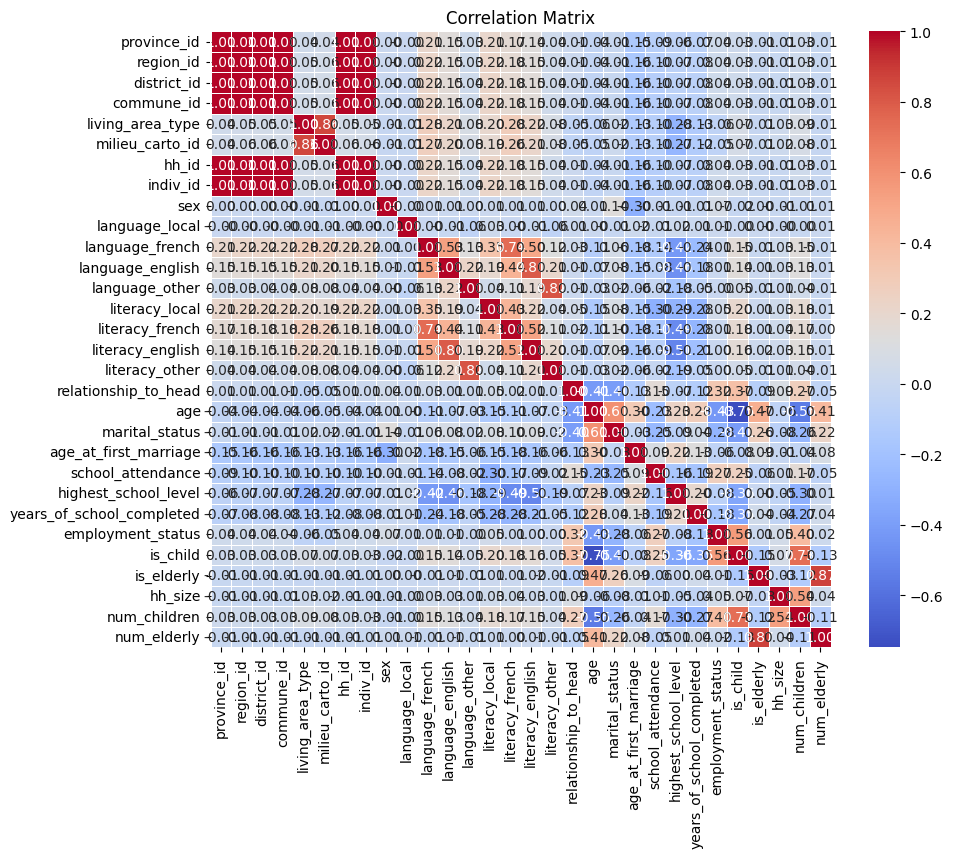

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numerical columns
correlation_matrix = df_hh.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Histogram of age at first marriage

The following plot provide to us the historgram of of the age at first mariage varible and the density of this variable.

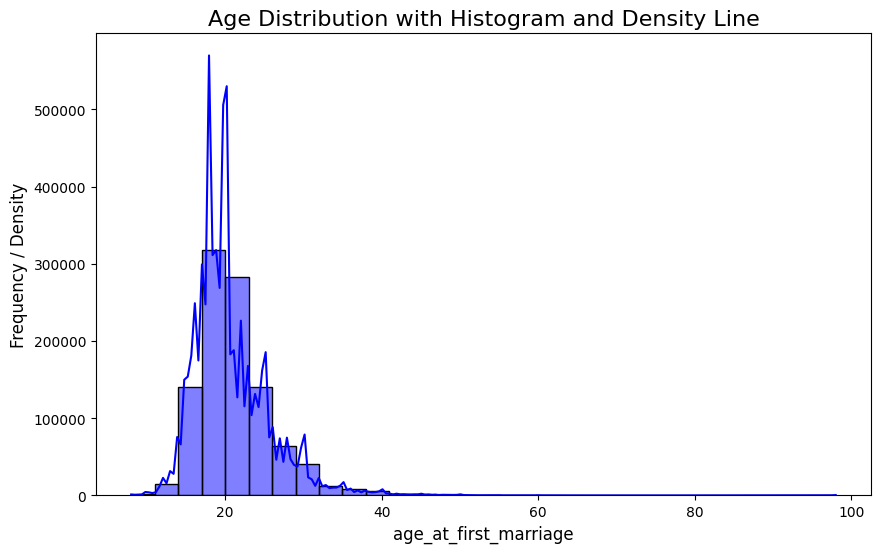

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))


sns.histplot(df_hh['age_at_first_marriage'], kde=True, color='blue', bins=30)

plt.title('Age Distribution with Histogram and Density Line', fontsize=16)
plt.xlabel('age_at_first_marriage', fontsize=12)
plt.ylabel('Frequency / Density', fontsize=12)

plt.show()

 ## Mean and Medium age_at_marriate by provide_id
 
 This step help us the calcalute the means and the median of the variable age at frist mariage by group

In [35]:
age_stats_by_province = df_hh.groupby('province_id')['age_at_first_marriage'].agg(
    mean_age_at_first_marriage='mean',
    median_age_at_first_marriage='median'
).reset_index()

print(age_stats_by_province)

   province_id  mean_age_at_first_marriage  median_age_at_first_marriage
0            1                       21.85                         20.00
1            2                       20.45                         20.00
2            3                       20.95                         20.00
3            4                       19.89                         19.00
4            5                       19.49                         18.00
5            6                       20.00                         19.00


# Prepare Data for ML

This step help us to prepare our dataset ready for machine learning model, the main idea behind this step is to tranform our dataset in to the ready for trainning machine learning model.

In [36]:
df = df_hh
df.head()

,province_id,region_id,district_id,commune_id,living_area_type,milieu_carto_id,hh_id,indiv_id,sex,language_local,...,age_at_first_marriage,school_attendance,highest_school_level,years_of_school_completed,employment_status,is_child,is_elderly,hh_size,num_children,num_elderly
0,1,14,141,14105,2,2,14105301010021015020230023,1410530101002011500230202302,2,1.00,...,16.00,1.00,2.00,2.00,7.00,False,True,2,0,1
1,2,23,232,23219,2,2,23219301010061009020610061,2321930101006010900610206105,2,1.00,...,NaN,2.00,3.00,6.00,5.00,False,False,2,0,0
2,6,62,623,62318,2,2,62318301050031006020210021,6231830105003010600210202101,2,1.00,...,25.00,1.00,2.00,2.00,1.00,False,False,1,0,0
3,2,25,252,25216,2,2,25216301070061008021260126,2521630107006010801260212606,2,1.00,...,NaN,0.00,NaN,NaN,8.00,True,False,3,2,0
4,6,62,621,62111,2,2,62111301100031008021080108,6211130110003010801080210804,2,1.00,...,NaN,9.00,1.00,1.00,NaN,True,False,1,1,0


## Generate Target Variable for Prediction

In [38]:
# ====================================
# ADD EARLY MARRIAGE VARIABLE
# ====================================
# if age_married < 18, then early_marriage = 1
df_hh['age_at_first_marriage'] = pd.to_numeric(df_hh['age_at_first_marriage'], errors='coerce')
df_hh['early_marriage'] = df_hh['age_at_first_marriage'].apply(lambda x: 1 if x < EARLY_MARRIAGE_AGE_THRESHOLD else 0)

## Drop Observations
- In this datasets, the marriage variabels are available for all individuals who are 12 years old or older. We can drop the observations where the marriage status is not available.
- Age at first marriage also makes sense for people who are currently married, divorced or widowed.

In [39]:
# Keep only individuals who are 12 years and above
df_marr = df[df['age'] >= 12]

In [40]:
# Keep only individuals who were ever married (currently married, divorced or widowed)
df_marr = df_marr[df_marr['marital_status'] != 1]
#print(df_marr.head())

## Features for Prediction

In [41]:
def convert2int(x):
    try:
        # Check if value is a float and has no decimal part
        if isinstance(x, float) and x.is_integer():
            return int(x)
        elif isinstance(x, int):  # Handle integers directly
            return x
        else:
            return np.nan  # Return NaN for anything else
    except:
        return np.nan

In [42]:
# ====================================
# PREPARE DATA FOR ML MODELS
# ====================================
# Convert columns with categorical data to pd.category type.
# Ensure that the categorical columns are of type int

# Target variable for prediction

Target = "early_marriage"


# Features to use for prediction

Features = [
    'province_id',
    'region_id',
    'district_id',
    'commune_id',
    'living_area_type',
    'milieu_carto_id',
    'sex',
    'language_local',
    'language_french',
    'language_english',
    'language_other',
    'literacy_local',
    'literacy_french',
    'literacy_english',
    'literacy_other',
    'relationship_to_head',
    'age',
    'marital_status',
    'age_at_first_marriage',
    'school_attendance',
    'highest_school_level',
    'years_of_school_completed',
    'employment_status'
]

categorical_columns = [
    'sex', 'language_local', 'language_french', 'language_english', 'language_other',
    'literacy_local', 'literacy_french', 'literacy_english', 'literacy_other',
    'relationship_to_head', 'marital_status', 'school_attendance', 'highest_school_level',
    'living_area_type', 'milieu_carto_id', 'province_id', 'region_id', 'district_id', 'commune_id'
]


for col in categorical_columns:
    df_hh[col] = df_hh[col].astype('category')
    df_hh[col] = df_hh[col].cat.codes  


print("Data Types after conversion:")
print(df_hh[categorical_columns].dtypes)


print("\nMissing Values in Target:")
print(df_hh[Target].isnull().sum())


print("\nMissing Values in Features:")
print(df_hh[Features].isnull().sum())

# Verify the changes


Data Types after conversion:
sex                      int8
language_local           int8
language_french          int8
language_english         int8
language_other           int8
literacy_local           int8
literacy_french          int8
literacy_english         int8
literacy_other           int8
relationship_to_head     int8
marital_status           int8
school_attendance        int8
highest_school_level     int8
living_area_type         int8
milieu_carto_id          int8
province_id              int8
region_id                int8
district_id              int8
commune_id              int16
dtype: object

Missing Values in Target:
0

Missing Values in Features:
province_id                        0
region_id                          0
district_id                        0
commune_id                         0
living_area_type                   0
milieu_carto_id                    0
sex                                0
language_local                     0
language_french                  

In [44]:
import pandas as pd



categorical_columns = [
  'sex', 'language_local', 'language_french', 'language_english', 'language_other',
  'literacy_local', 'literacy_french', 'literacy_english', 'literacy_other',
  'relationship_to_head', 'marital_status', 'school_attendance', 'highest_school_level',
  'living_area_type', 'milieu_carto_id', 'province_id', 'region_id', 'district_id', 'commune_id'
]


continuous_columns = [
  'age', 'age_at_first_marriage', 'years_of_school_completed'
]


def impute_missing_values(df):
    """
    This function help us the fill missing value of categories and contnious variable by replaced categories
    variable by mode and continous varible by the mean. the input is the dataframe.
    """
    
    for col in categorical_columns:
        mode_value = df[col].mode()[0] 
        df[col].fillna(mode_value, inplace=True)
        

    
    for col in continuous_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        median_value = df[col].median()  
        df[col].fillna(median_value, inplace=True)
    return df


df_hh_imputed = impute_missing_values(df_hh.copy())  


print("\nMissing Values After Imputation:")
print(df_hh_imputed.isnull().sum())


print("\nFirst 5 Rows After Imputation:")
print(df_hh_imputed.head())

/tmp/ipykernel_183523/3189061956.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)
/tmp/ipykernel_183523/3189061956.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

/tmp/ipykernel_183523/3189061956.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
/tmp/ipykernel_183523/3189061956.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 


Missing Values After Imputation:
province_id                       0
region_id                         0
district_id                       0
commune_id                        0
living_area_type                  0
milieu_carto_id                   0
hh_id                             0
indiv_id                          0
sex                               0
language_local                    0
language_french                   0
language_english                  0
language_other                    0
literacy_local                    0
literacy_french                   0
literacy_english                  0
literacy_other                    0
relationship_to_head              0
age                               0
marital_status                    0
age_at_first_marriage             0
school_attendance                 0
highest_school_level              0
years_of_school_completed         0
employment_status            370819
is_child                          0
is_elderly                    

In [22]:
# ============================================
# DEAL WITH OUTLIERS IN CONTINUOUS VARIABLES
# ============================================

# Age: Drop all observations where age > 100
df_hh = df_hh[df_hh['age'] <= 100]

# HH_SIZE: Drop all observations where hh_size > 20
df_hh = df_hh[df_hh['hh_size'] <= 20]

# NUM_CHILDREN: Drop all observations where num_children > 1
df_hh = df_hh[df_hh['num_children'] <= 1]

# NUM_ELDERLY: Drop all observations where num_elderly > 1
df_hh = df_hh[df_hh['num_elderly'] <= 1]

# ============================================
# Verify the changes
# ============================================
# Check the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_hh.shape[0]}")

# Check the first few rows to ensure that outliers have been removed
print(df_hh.head())


Number of rows after outlier removal: 2303016
  province_id region_id district_id commune_id living_area_type  \
0           1        14         141      14105                2   
1           2        23         232      23219                2   
2           6        62         623      62318                2   
4           6        62         621      62111                2   
7           4        42         425      42512                2   

  milieu_carto_id                       hh_id                      indiv_id  \
0               2  14105301010021015020230023  1410530101002011500230202302   
1               2  23219301010061009020610061  2321930101006010900610206105   
2               2  62318301050031006020210021  6231830105003010600210202101   
4               2  62111301100031008021080108  6211130110003010801080210804   
7               2  42512301110011011022770277  4251230111001011102770227703   

  sex language_local  ... school_attendance highest_school_level  \
0   2   

25/01/25 03:34:11 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [45]:
# ============================================
# ONE-HOT ENCODING FOR CATEGORICAL VARIABLES
# ============================================
# One-hot encode the categorical variables
# using pd.get_dummies function
# Make sure you one-hot encode all the categorical variables

# Convert True/False to 1/0

# One-hot encode the categorical variables
df_hh = pd.get_dummies(df_hh, columns=categorical_columns)

# Convert True/False to 1/0
df_hh['is_child'] = df_hh['is_child'].astype(int)
df_hh['is_elderly'] = df_hh['is_elderly'].astype(int)

df_hh = df_hh.dropna()

In [46]:
def random_forest_with_sklearn(df, num_estimators=100):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=num_estimators, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    return rf_model

In [47]:
def evaluate_models_sklearn(df):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=100, random_state=42),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))

In [48]:
# Build and evaluate the models using the df_marr2_dummies DataFrame
evaluate_models_sklearn(df_hh)

/home/linuce/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.8064356036665804 |
|    Random Forest    | 0.999779428295108  |
|  Gradient Boosting  |        1.0         |
|     Extra Trees     | 0.8980873888127728 |
+---------------------+--------------------+


In [49]:
def evaluate_models_spark(df, target_var):
    """
    Evaluate multiple machine learning models using Spark MLlib on the given DataFrame.

    Parameters:
    ----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing features and the target variable.
    target_var : str
        The name of the target variable column.

    Returns:
    -------
    None
    """
    # Define the features
    features = [col for col in df.columns if col != target_var]

    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df = assembler.transform(df).select("features", target_var)

    # Split the data into training and testing sets
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(maxIter=50).setFeaturesCol("features").setLabelCol(target_var),
        "Random Forest": RandomForestClassifier(numTrees=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Gradient Boosting": GBTClassifier(maxIter=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Decision Tree": DecisionTreeClassifier(seed=42).setFeaturesCol("features").setLabelCol(target_var),
    }

    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_var, predictionCol="prediction", metricName="accuracy")

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        # Train the model
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate accuracy
        accuracy = evaluator.evaluate(predictions)

        # Append results
        results.append([name, accuracy])

    # Print results in a tabular format
    from tabulate import tabulate
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))


In [54]:
sparkDF=spark.createDataFrame(df_hh)
evaluate_models_spark(sparkDF, "early_marriage")

ConnectionRefusedError: [Errno 111] Connection refused